# CATBOOST MODELO SELECCIONADO

**Objetivo:** Entrenar CatBoost optimizado en TRAIN y evaluar en TEST para las 3 fases temporales (T0, T1, T2), con luego aplicar la explicabilidad mediante SHAP.

**IMPORTANTE:** Este notebook se ejecuta UNA SOLA VEZ. Los resultados de TEST son el reporte final.

Fases temporales:
- T0 (Matrícula)          : Variables disponibles al momento de inscripción
- T1 (Fin 1er Semestre)   : T0 + variables académicas del 1er semestre, información de matrícula y deudor
- T2 (Fin 2do Semestre)   : T1 + variables académicas del 2do semestre

Preprocesamiento específico para CatBoost:
- No requiere escalado
- Manejo nativo de categóricas (sin Label Encoding)
- Target Encoding para 'course' (alta cardinalidad)

Pipeline:
1. Cargar datos y mejores hiperparámetros de Optuna resultantes de etapa de entrenamiento con validación cruzada
2. Entrenar modelo final en X_train completo
3. Evaluar en X_test 
4. Comparación entre fases T0, T1, T2
5. Guardar modelos finales para producción

## 0. Librerias y configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
import json
warnings.filterwarnings('ignore')

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder

# Modelo
from catboost import CatBoostClassifier
import catboost

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# Target Encoding
from category_encoders import TargetEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directorio de salida
OUTPUT_DIR = "../outputs/figures/modelado/CatBoost/"
OUTPUT_DIR_MODELS = "../outputs/models/CatBoost/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)

# mlflow
import mlflow
import mlflow.sklearn

## 1. Carga de datos preprocesados

In [2]:
# Cargar dataset preprocesado
df = pd.read_csv('../data/processed/preprocessed_data.csv')

print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
print(df['target_binario'].value_counts())
print(f"\nRatio de desbalance: {df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]:.2f}:1")

df.head()

Dataset cargado: 4424 filas x 36 columnas
target_binario
0    3003
1    1421
Name: count, dtype: int64

Ratio de desbalance: 2.11:1


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,target_binario
0,5,171,1,122.0000,127.3000,1,0,0,1,1,0,20,0,0,0,0,0,0.0000,0,0,0,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,1
1,1,9254,1,160.0000,142.5000,1,0,0,0,1,0,19,0,0,6,6,6,14.0000,0,0,6,6,6,13.6667,0,13.9000,-0.3000,0.7900,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0
2,5,9070,1,122.0000,124.8000,1,0,0,0,1,0,19,0,0,6,0,0,0.0000,0,0,6,0,0,0.0000,0,10.8000,1.4000,1.7400,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1
3,2,9773,1,122.0000,119.6000,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4000,0,9.4000,-0.8000,-3.1200,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0
4,1,8014,0,100.0000,141.5000,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0000,0,13.9000,-0.3000,0.7900,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0


## 2. Definición de variables por fase temporal (T0, T1, T2)

In [3]:
# TARGET
TARGET = 'target_binario'

# -----------------------------------------------------------------------------
# VARIABLES BINARIAS (no requieren encoding, ya son 0/1)
# -----------------------------------------------------------------------------
VARS_BINARIAS_T0 = [
    'daytimeevening_attendance',
    'displaced',
    'educational_special_needs',
    'gender',
    'scholarship_holder',
    'international',
    'is_single'
]

VARS_BINARIAS_T1 = [
    'debtor',
    'tuition_fees_up_to_date'
]

# -----------------------------------------------------------------------------
# VARIABLES NUMÉRICAS (NO requieren escalado para CatBoost)
# -----------------------------------------------------------------------------
VARS_NUMERICAS_T0 = [
    'age_at_enrollment',
    'admission_grade',
    'previous_qualification_grade'
]

VARS_NUMERICAS_T1 = [
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp'
]

VARS_NUMERICAS_T2 = [
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS AGRUPADAS (CatBoost las maneja nativamente)
# -----------------------------------------------------------------------------
VARS_CATEGORICAS_AGRUPADAS_T0 = [
    'application_mode_risk',
    'previous_qualification_risk',
    'mothers_qualification_level',
    'fathers_qualification_level',
    'mothers_occupation_level',
    'fathers_occupation_level'
]

# -----------------------------------------------------------------------------
# VARIABLES CATEGÓRICAS PARA TARGET ENCODING (alta cardinalidad)
# -----------------------------------------------------------------------------
VARS_TARGET_ENCODING_T0 = ['course']

# -----------------------------------------------------------------------------
# VARIABLE ORDINAL (se trata como numérica)
# -----------------------------------------------------------------------------
VARS_ORDINALES_T0 = ['application_order']

# =============================================================================
# COMPOSICIÓN DE VARIABLES POR FASE TEMPORAL
# =============================================================================

# T0: Variables disponibles al momento de matrícula
VARS_T0 = (
    VARS_BINARIAS_T0 +
    VARS_NUMERICAS_T0 +
    VARS_CATEGORICAS_AGRUPADAS_T0 +
    VARS_TARGET_ENCODING_T0 +
    VARS_ORDINALES_T0
)

# T1: T0 + variables del 1er semestre
VARS_T1 = (
    VARS_T0 +
    VARS_BINARIAS_T1 +
    VARS_NUMERICAS_T1
)

# T2: T1 + variables del 2do semestre
VARS_T2 = (
    VARS_T1 +
    VARS_NUMERICAS_T2
)

print("================================================================================")
print("  VARIABLES POR FASE TEMPORAL")
print("================================================================================")
print(f"\n T0 (Matrícula): {len(VARS_T0)} variables")
print(f" T1 (Fin 1er Sem): {len(VARS_T1)} variables (+{len(VARS_T1) - len(VARS_T0)})")
print(f" T2 (Fin 2do Sem): {len(VARS_T2)} variables (+{len(VARS_T2) - len(VARS_T1)})")

  VARIABLES POR FASE TEMPORAL

 T0 (Matrícula): 18 variables
 T1 (Fin 1er Sem): 29 variables (+11)
 T2 (Fin 2do Sem): 35 variables (+6)


## 3. Split Train/Test

In [4]:
# Split se hace en totalidad del dataste, posteriormente se seleccionan las variables según la fase temporal para entrenemiento y evaluación

X = df[VARS_T2].copy()
y = df[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)


print("================================================================================")
print("  DATOS PARA ENTRENAMIENTO")
print("================================================================================")
print(f"\nTotal registros: {X.shape[0]}")
print(f"Total variables: {X.shape[1]}")

print(f"\nDistribución del target:")
print(y.value_counts())
print(f"Ratio de desbalance: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

  DATOS PARA ENTRENAMIENTO

Total registros: 4424
Total variables: 35

Distribución del target:
target_binario
0    3003
1    1421
Name: count, dtype: int64
Ratio de desbalance: 2.11:1


## 4. Funciones de preprocesamiento para CATBOOST

In [5]:
def obtiene_variables_por_fase(fase):
    # Retorna las listas de variables según la fase temporal
    if fase == 'T0':
        return {
            'binarias': VARS_BINARIAS_T0,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T0
        }
    elif fase == 'T1':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T1
        }
    elif fase == 'T2':
        return {
            'binarias': VARS_BINARIAS_T0 + VARS_BINARIAS_T1,
            'numericas': VARS_NUMERICAS_T0 + VARS_ORDINALES_T0 + VARS_NUMERICAS_T1 + VARS_NUMERICAS_T2,
            'categoricas_nativas': VARS_CATEGORICAS_AGRUPADAS_T0,
            'categoricas_te': VARS_TARGET_ENCODING_T0,
            'all': VARS_T2
        }
    else:
        raise ValueError(f"Fase no válida: {fase}. Usar 'T0', 'T1', o 'T2'")


def preprocesamiento_catboost(X_train, X_test, y_train, fase):
    """
    Preprocesa los datos para CatBoost:
    - NO Label Encoding (CatBoost maneja categóricas nativas)
    - Solo Target Encoding para 'course' (alta cardinalidad)
    - Retorna índices de variables categóricas para CatBoost
    """
    variables_fase = obtiene_variables_por_fase(fase)
    
    # Seleccionar solo las variables de la fase
    X_train_fase = X_train[variables_fase['all']].copy()
    X_test_fase = X_test[variables_fase['all']].copy()
    
    # -------------------------------------------------------------------------
    # 1. TARGET ENCODING para 'course' (alta cardinalidad)
    # -------------------------------------------------------------------------
    te = TargetEncoder(cols=variables_fase['categoricas_te'], smoothing=0.3)
    
    for col in variables_fase['categoricas_te']:
        X_train_fase[col + '_encoded'] = te.fit_transform(X_train_fase[[col]], y_train)[col]
        X_test_fase[col + '_encoded'] = te.transform(X_test_fase[[col]])[col]
        # Eliminar columna original
        X_train_fase = X_train_fase.drop(columns=[col])
        X_test_fase = X_test_fase.drop(columns=[col])
    
    # -------------------------------------------------------------------------
    # 2. Convertir categóricas a string (CatBoost las requiere así)
    # -------------------------------------------------------------------------
    for col in variables_fase['categoricas_nativas']:
        X_train_fase[col] = X_train_fase[col].astype(str)
        X_test_fase[col] = X_test_fase[col].astype(str)
    
    # -------------------------------------------------------------------------
    # 3. Obtener índices de columnas categóricas para CatBoost
    # -------------------------------------------------------------------------
    cat_features_idx = [X_train_fase.columns.get_loc(c) for c in variables_fase['categoricas_nativas']]
    cat_features_names = variables_fase['categoricas_nativas']
    
    # -------------------------------------------------------------------------
    # Guardar información
    # -------------------------------------------------------------------------
    variables = X_train_fase.columns.tolist()
    preprocessors = {
        'target_encoder': te,
        'feature_names': variables,
        'cat_features_idx': cat_features_idx,
        'cat_features_names': cat_features_names
    }
    
    return X_train_fase, X_test_fase, preprocessors

In [6]:
# MEJORES HIPERPARÁMETROS DE OPTUNA 
BEST_PARAMS = {
    'T0': {
        'iterations': 219,
        'learning_rate': 0.29572919322251784,
        'depth': 7,
        'l2_leaf_reg': 1.0859325539562723,
        'border_count': 131,
        'bagging_temperature': 0.3073686643512338,
        'random_strength': 9.580055402844472,
        'auto_class_weights': 'Balanced'
    },
    'T1': {
        'iterations': 724,
        'learning_rate': 0.17178329359598113,
        'depth': 4,
        'l2_leaf_reg': 2.647297025653965,
        'border_count': 182,
        'bagging_temperature': 6.338562112382173,
        'random_strength': 3.3848344546818883,
        'auto_class_weights': 'SqrtBalanced'
    },
    'T2': {
        'iterations': 925,
        'learning_rate': 0.10375434829158396,
        'depth': 6,
        'l2_leaf_reg': 1.5537542842917214,
        'border_count': 223,
        'bagging_temperature': 0.26368084405807757,
        'random_strength': 6.090738634337445,
        'auto_class_weights': 'SqrtBalanced'
    }
}

print("Hiperparámetros óptimos listos para T0, T1, T2")

Hiperparámetros óptimos listos para T0, T1, T2


## 5. Funciones entrenamiento

In [ ]:
# Entrenamiento con parámetros por defecto
def entrena_y_evalua_catboost(X_train, X_test, y_train, y_test, fase, best_params):
    
    mlflow.end_run()
    
    # Preprocesamiento
    X_train_prep, X_test_prep, preprocessors = preprocesamiento_catboost(
        X_train, X_test, y_train, fase
    )

    print("================================================================================")
    print(f"  ENTRENAMIENTO CATBOOST - FASE {fase}")
    print("================================================================================")
    print(f"\nVariables: {X_train_prep.shape[1]}")
    print(f"Train: {X_train_prep.shape[0]} | Test: {X_test_prep.shape[0]}")
    print(f"Variables categóricas: {len(preprocessors['cat_features_idx'])}")

    # Parámetros del modelo
    params = {
        **best_params,
        'cat_features': preprocessors['cat_features_idx'],
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'random_seed': RANDOM_STATE,
        'verbose': False
    }
    
    print(f"\nHiperparámetros óptimos:")
    for k, v in best_params.items():
        print(f" - {k}: {v}")


    with mlflow.start_run(run_name="CatBoost_mejor_modelo"):
        mlflow.set_tag("modelo", 'CatBoost Final')
        mlflow.set_tag("tipo", 'Evalución')
        
        # Entrenar modelo final
        print(f"\nEntrenamiento de modelo final CatBoost")
        modelo = CatBoostClassifier(**params)
        modelo.fit(
            X_train_prep, y_train, 
            eval_set=(X_test_prep, y_test), 
            verbose=False)
        
        mlflow.log_params(modelo.get_params())
      
        # Curva de pérdida
        train_loss = modelo.get_evals_result()['learn']['Logloss']
        val_loss = modelo.get_evals_result()['validation']['Logloss']
        best_iter = np.argmin(val_loss)
        gap_loss = train_loss[-1] - val_loss[-1]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(train_loss, label='Train', color='#3498DB', linewidth=2)
        ax.plot(val_loss, label='Test', color='#E74C3C', linewidth=2)
        ax.axvline(x=best_iter, color='green', linestyle='--', alpha=0.7, label=f'Best: {best_iter}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Logloss')
        ax.set_title(f'Curva de Pérdida - CatBoost {fase} | Gap: {gap_loss:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}curva_perdida_{fase}.png', dpi=150)
        plt.show()
    
        # Predicciones
        y_train_pred = modelo.predict(X_train_prep)
        y_train_proba = modelo.predict_proba(X_train_prep)[:, 1]
        y_test_pred = modelo.predict(X_test_prep)
        y_test_proba = modelo.predict_proba(X_test_prep)[:, 1]
        
        # Métricas globales
        metricas_train = {
            'accuracy': accuracy_score(y_train, y_train_pred),
            'precision': precision_score(y_train, y_train_pred),
            'recall': recall_score(y_train, y_train_pred),
            'f1': f1_score(y_train, y_train_pred),
            'roc_auc': roc_auc_score(y_train, y_train_proba)
        }
        metricas_test = {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred),
            'roc_auc': roc_auc_score(y_test, y_test_proba)
        }
        
        # Métricas por clase
        metricas_por_clase = {
            'clase_0': {
                'precision': precision_score(y_test, y_test_pred, pos_label=0),
                'recall': recall_score(y_test, y_test_pred, pos_label=0),
                'f1': f1_score(y_test, y_test_pred, pos_label=0),
                'support': int((y_test == 0).sum())
            },
            'clase_1': {
                'precision': precision_score(y_test, y_test_pred, pos_label=1),
                'recall': recall_score(y_test, y_test_pred, pos_label=1),
                'f1': f1_score(y_test, y_test_pred, pos_label=1),
                'support': int((y_test == 1).sum())
            }
        }
        
        # Guarda en mlflow
        mlflow.log_metric("test_accuracy", metricas_test['accuracy'])
        mlflow.log_metric("test_precision", metricas_test['precision'])
        mlflow.log_metric("test_recall", metricas_test['recall'])
        mlflow.log_metric("test_f1", metricas_test['f1'])
        mlflow.log_metric("test_roc_auc", metricas_test['roc_auc'])
        
        mlflow.log_metric("train_f1", metricas_train['f1'])
        mlflow.log_metric("gap_f1", metricas_train['f1'] - metricas_test['f1'])
        mlflow.log_metric("gap_loss", gap_loss)
        
        mlflow.log_metric("test_f1_desertor", metricas_por_clase['clase_1']['f1'])
        mlflow.log_metric("test_f1_no_desertor", metricas_por_clase['clase_0']['f1'])
        
        mlflow.set_tag("fase", fase)
        mlflow.log_artifact(f'{OUTPUT_DIR}curva_perdida_{fase}.png')        

        # Resultados
        print(f"\n{'Métrica':<12} {'Train':>10} {'Test':>10} {'Gap':>10}")
        print("================================================================================")
        for m in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
            print(f"{m:<12} {metricas_train[m]:>10.4f} {metricas_test[m]:>10.4f} {metricas_train[m]-metricas_test[m]:>10.4f}")

        
        print(f"\n--- Métricas por Clase (TEST) ---")
        print(f"{'Clase':<15} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
        print("================================================================================")
        print(f"{'No Desertor':<15} {metricas_por_clase['clase_0']['precision']:>10.4f} {metricas_por_clase['clase_0']['recall']:>10.4f} {metricas_por_clase['clase_0']['f1']:>10.4f} {metricas_por_clase['clase_0']['support']:>10}")
        print(f"{'Desertor':<15} {metricas_por_clase['clase_1']['precision']:>10.4f} {metricas_por_clase['clase_1']['recall']:>10.4f} {metricas_por_clase['clase_1']['f1']:>10.4f} {metricas_por_clase['clase_1']['support']:>10}")
        
        # ROC curve data
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    
        mlflow.catboost.log_model(cb_model=modelo,artifact_path="modelo final", registered_model_name="catboost-final-val")
        mlflow.end_run()

    return {
        'modelo': modelo,
        'metricas_train': metricas_train,
        'metricas_test': metricas_test,
        'metricas_por_clase': metricas_por_clase,
        'X_train_prep': X_train_prep,
        'X_test_prep': X_test_prep,
        'y_train': y_train,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'preprocessors': preprocessors,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_iter': best_iter,
        'gap_loss': gap_loss,
        'roc': {'fpr': fpr, 'tpr': tpr, 'auc': metricas_test['roc_auc']}
    }   
    

## 6. Entrenamiento y Evaluación

### Fase T0

  ENTRENAMIENTO CATBOOST - FASE T0

Variables: 18
Train: 3539 | Test: 885
Variables categóricas: 6

Hiperparámetros óptimos:
 - iterations: 219
 - learning_rate: 0.29572919322251784
 - depth: 7
 - l2_leaf_reg: 1.0859325539562723
 - border_count: 131
 - bagging_temperature: 0.3073686643512338
 - random_strength: 9.580055402844472
 - auto_class_weights: Balanced

Entrenamiento de modelo final CatBoost


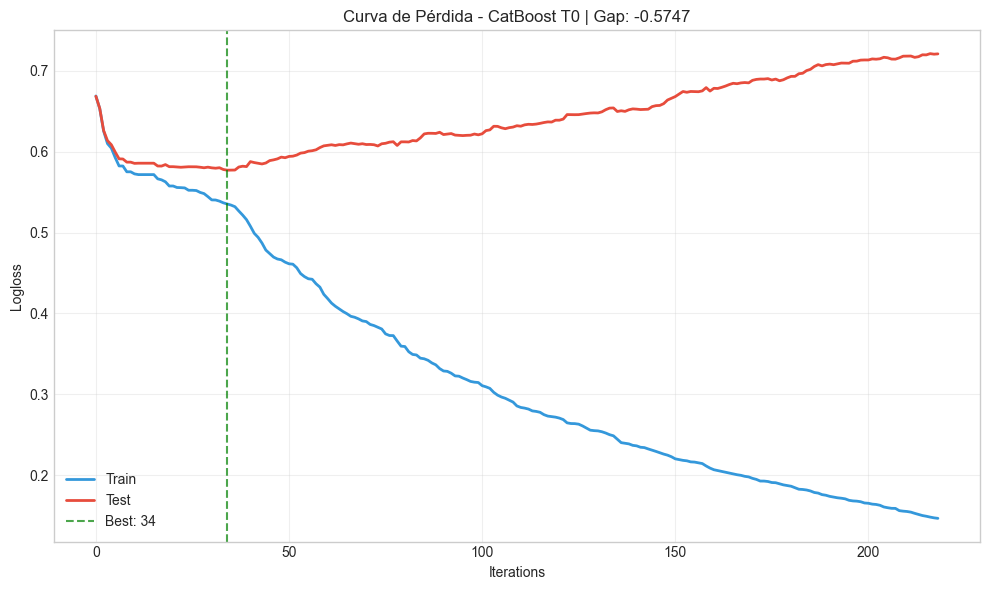

2026/02/17 21:40:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.7169     0.6972     0.0197
precision        0.5461     0.5209     0.0252
recall           0.7027     0.7007     0.0020
f1               0.6146     0.5976     0.0170
roc_auc          0.7850     0.7656     0.0194

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.8310     0.6955     0.7572        601
Desertor            0.5209     0.7007     0.5976        284


Registered model 'catboost-final-val' already exists. Creating a new version of this model...
2026/02/17 21:40:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: catboost-final-val, version 3


🏃 View run CatBoost_mejor_modelo at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/e3ffc1ab2d6e484cbc8acfd6c2d06902
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '3' of model 'catboost-final-val'.


In [13]:
results_T0 = entrena_y_evalua_catboost(X_train, X_test, y_train, y_test, 'T0', BEST_PARAMS['T0'])

### Fase T1

  ENTRENAMIENTO CATBOOST - FASE T1

Variables: 29
Train: 3539 | Test: 885
Variables categóricas: 6

Hiperparámetros óptimos:
 - iterations: 724
 - learning_rate: 0.17178329359598113
 - depth: 4
 - l2_leaf_reg: 2.647297025653965
 - border_count: 182
 - bagging_temperature: 6.338562112382173
 - random_strength: 3.3848344546818883
 - auto_class_weights: SqrtBalanced

Entrenamiento de modelo final CatBoost


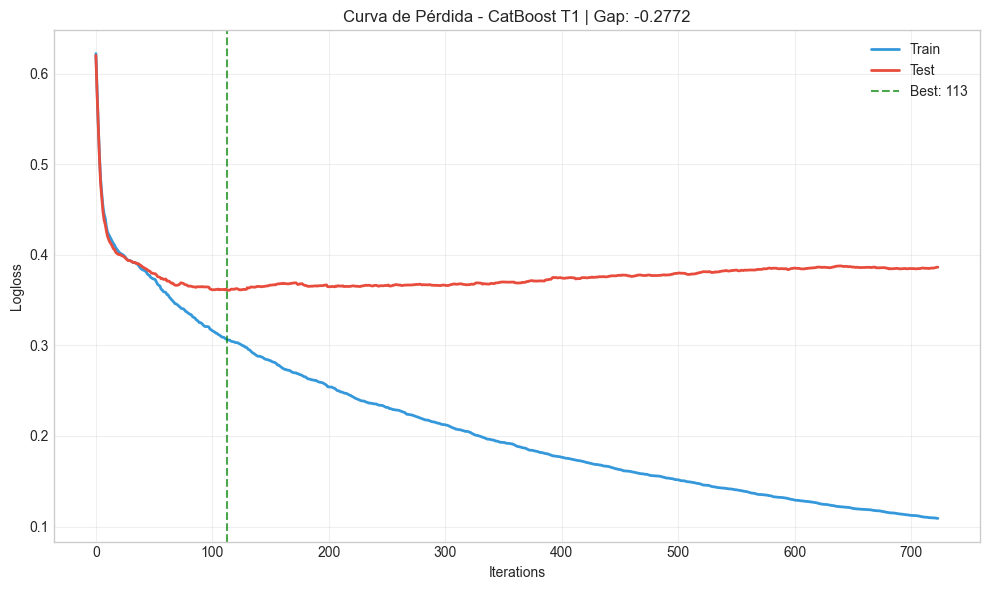

2026/02/17 21:41:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.9740     0.8723     0.1017
precision        0.9612     0.8276     0.1336
recall           0.9578     0.7606     0.1972
f1               0.9595     0.7927     0.1668
roc_auc          0.9967     0.9028     0.0939

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.8910     0.9251     0.9078        601
Desertor            0.8276     0.7606     0.7927        284


Registered model 'catboost-final-val' already exists. Creating a new version of this model...
2026/02/17 21:41:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: catboost-final-val, version 4


🏃 View run CatBoost_mejor_modelo at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/bef9b3435c0f4a718e292c49d2082dc4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '4' of model 'catboost-final-val'.


In [14]:
results_T1 = entrena_y_evalua_catboost(X_train, X_test, y_train, y_test, 'T1', BEST_PARAMS['T1'])

### Fase T2

  ENTRENAMIENTO CATBOOST - FASE T2

Variables: 35
Train: 3539 | Test: 885
Variables categóricas: 6

Hiperparámetros óptimos:
 - iterations: 925
 - learning_rate: 0.10375434829158396
 - depth: 6
 - l2_leaf_reg: 1.5537542842917214
 - border_count: 223
 - bagging_temperature: 0.26368084405807757
 - random_strength: 6.090738634337445
 - auto_class_weights: SqrtBalanced

Entrenamiento de modelo final CatBoost


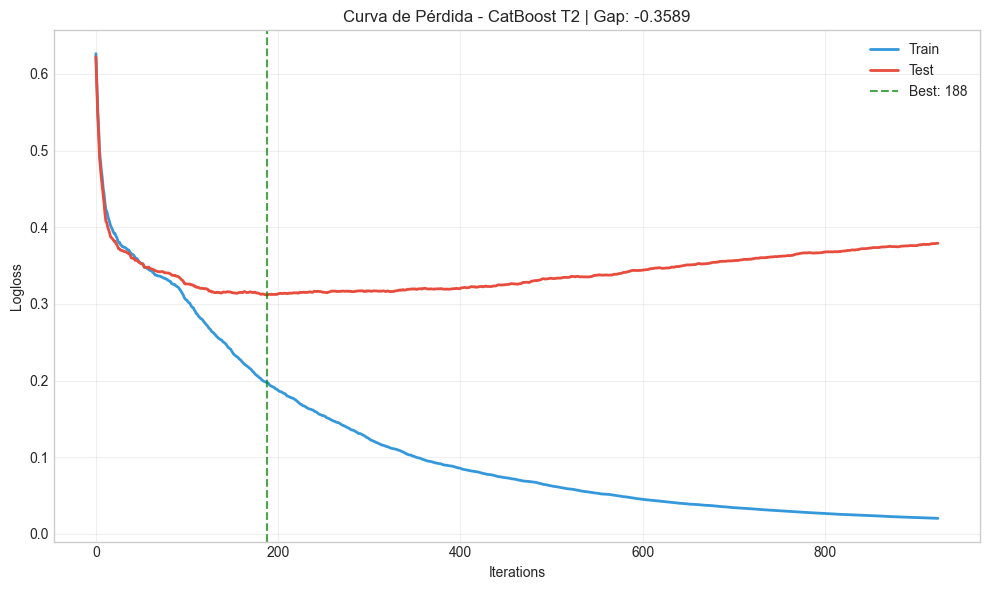

2026/02/17 21:42:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrica           Train       Test        Gap
accuracy         0.9548     0.8938     0.0610
precision        0.9519     0.8654     0.0865
recall           0.9050     0.7923     0.1128
f1               0.9279     0.8272     0.1007
roc_auc          0.9904     0.9292     0.0612

--- Métricas por Clase (TEST) ---
Clase            Precision     Recall         F1    Support
No Desertor         0.9056     0.9418     0.9233        601
Desertor            0.8654     0.7923     0.8272        284


Registered model 'catboost-final-val' already exists. Creating a new version of this model...
2026/02/17 21:42:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: catboost-final-val, version 5


🏃 View run CatBoost_mejor_modelo at: http://127.0.0.1:5000/#/experiments/294382465810157940/runs/5d1395164f2545c9a76a0c4174093fa0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/294382465810157940


Created version '5' of model 'catboost-final-val'.


In [15]:
results_T2 = entrena_y_evalua_catboost(X_train, X_test, y_train, y_test, 'T2', BEST_PARAMS['T2'])

## 7. Curva ROC Comparativa

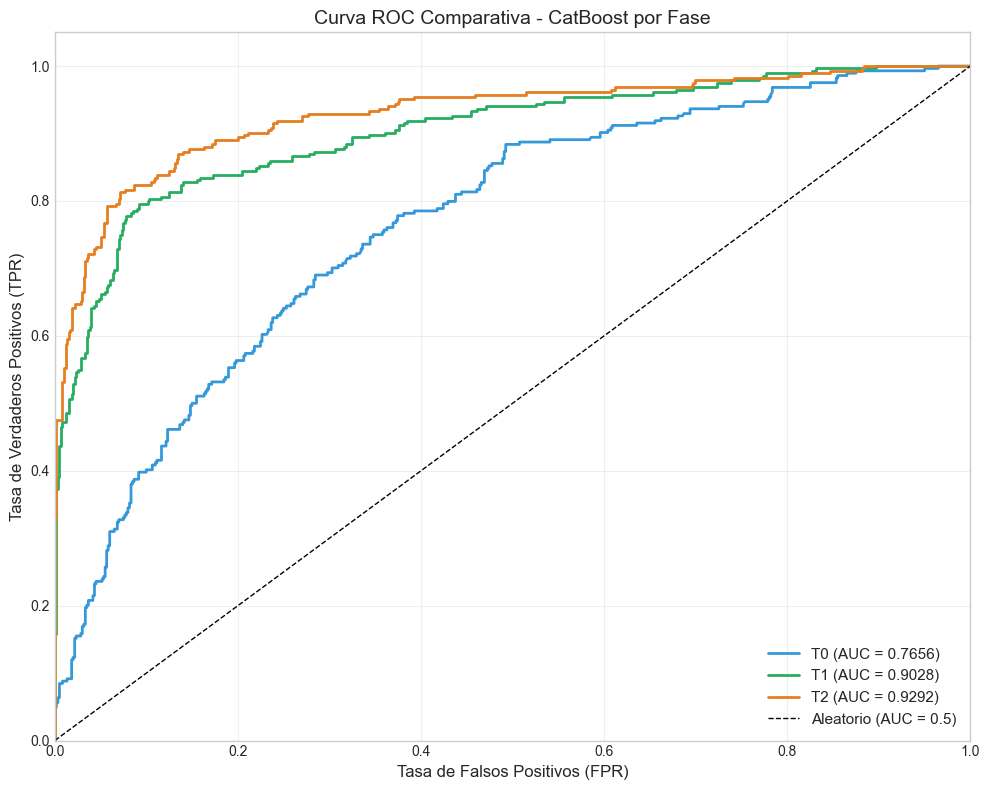

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'T0': '#3498DB', 'T1': '#27AE60', 'T2': '#E67E22'}

for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    ax.plot(results['roc']['fpr'], results['roc']['tpr'], 
            color=colors[fase], linewidth=2,
            label=f"{fase} (AUC = {results['roc']['auc']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
ax.set_title('Curva ROC Comparativa - CatBoost por Fase', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}curva_roc_comparativa.png', dpi=150)
plt.show()

## 8. Matriz de Confusión

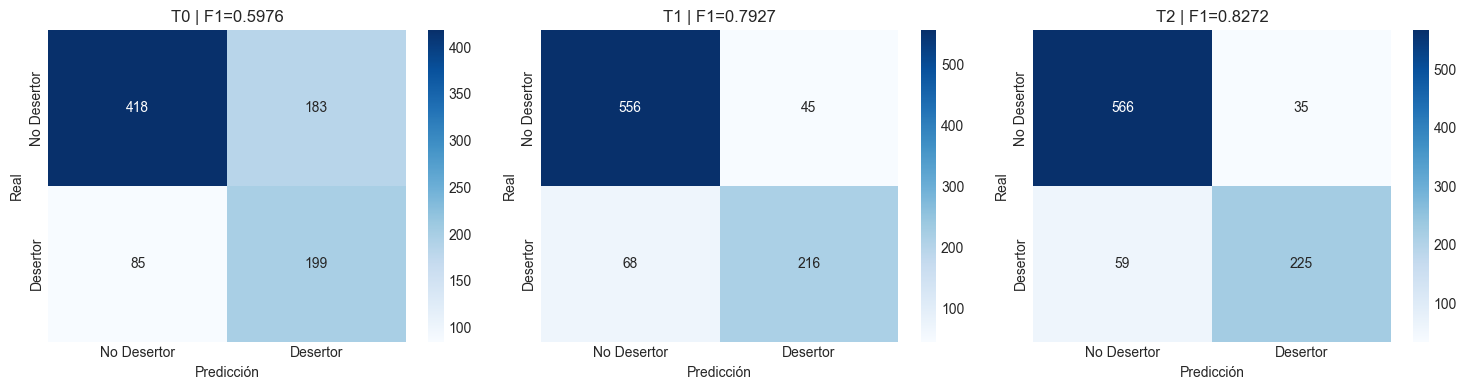

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (fase, results) in zip(axes, [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]):
    cm = confusion_matrix(y_test, results['y_test_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Desertor', 'Desertor'],
                yticklabels=['No Desertor', 'Desertor'])
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(f"{fase} | F1={results['metricas_test']['f1']:.4f}")

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}matrices_confusion.png', dpi=150)
plt.show()

## 9. Tabla Comparativa Final

In [18]:
print("================================================================================")
print("  COMPARACIÓN GLOBAL - TEST")
print("================================================================================")
print(f"\n{'Fase':<6} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'ROC-AUC':>10} {'Gap Loss':>10}")
print("================================================================================")
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    m = results['metricas_test']
    print(f"{fase:<6} {m['accuracy']:>10.4f} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f} {m['roc_auc']:>10.4f} {results['gap_loss']:>10.4f}")

print("================================================================================")
print("  MÉTRICAS POR CLASE - TEST")
print("================================================================================")
print(f"\n{'Fase':<6} {'Clase':<15} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("================================================================================")
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    mc = results['metricas_por_clase']
    print(f"{fase:<6} {'No Desertor':<15} {mc['clase_0']['precision']:>10.4f} {mc['clase_0']['recall']:>10.4f} {mc['clase_0']['f1']:>10.4f} {mc['clase_0']['support']:>10}")
    print(f"{'':6} {'Desertor':<15} {mc['clase_1']['precision']:>10.4f} {mc['clase_1']['recall']:>10.4f} {mc['clase_1']['f1']:>10.4f} {mc['clase_1']['support']:>10}")
    print("================================================================================")

  COMPARACIÓN GLOBAL - TEST

Fase     Accuracy  Precision     Recall         F1    ROC-AUC   Gap Loss
T0         0.6972     0.5209     0.7007     0.5976     0.7656    -0.5747
T1         0.8723     0.8276     0.7606     0.7927     0.9028    -0.2772
T2         0.8938     0.8654     0.7923     0.8272     0.9292    -0.3589
  MÉTRICAS POR CLASE - TEST

Fase   Clase            Precision     Recall         F1    Support
T0     No Desertor         0.8310     0.6955     0.7572        601
       Desertor            0.5209     0.7007     0.5976        284
T1     No Desertor         0.8910     0.9251     0.9078        601
       Desertor            0.8276     0.7606     0.7927        284
T2     No Desertor         0.9056     0.9418     0.9233        601
       Desertor            0.8654     0.7923     0.8272        284


## 10. Guardar Modelos y Datos para SHAP

**Guarda todo para continuar con análisis SHAP sin re-entrenar**

In [19]:
print("================================================================================")
print("  GUARDANDO MODELOS Y DATOS")
print("================================================================================")

for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    # Modelo
    results['modelo'].save_model(f'{OUTPUT_DIR_MODELS}catboost_final_{fase}.cbm')
    
    # Datos para SHAP
    datos = {
        'X_test_prep': results['X_test_prep'],
        'X_train_prep': results['X_train_prep'],
        'y_test': results['y_test'],
        'y_train': results['y_train'],
        'y_test_pred': results['y_test_pred'],
        'y_test_proba': results['y_test_proba'],
        'feature_names': results['preprocessors']['feature_names'],
        'cat_features_idx': results['preprocessors']['cat_features_idx'],
        'metricas_train': results['metricas_train'],
        'metricas_test': results['metricas_test'],
        'metricas_por_clase': results['metricas_por_clase']
    }
    joblib.dump(datos, f'{OUTPUT_DIR_MODELS}datos_evaluacion_{fase}.joblib')
    joblib.dump(results['preprocessors'], f'{OUTPUT_DIR_MODELS}preprocessors_{fase}.joblib')
    
    print(f"{fase} guardado")

# Guardar params y métricas
with open(f'{OUTPUT_DIR_MODELS}best_params.json', 'w') as f:
    json.dump(BEST_PARAMS, f, indent=2)

metricas_all = []
for fase, results in [('T0', results_T0), ('T1', results_T1), ('T2', results_T2)]:
    metricas_all.append({'fase': fase, 'dataset': 'train', **results['metricas_train']})
    metricas_all.append({'fase': fase, 'dataset': 'test', **results['metricas_test']})
pd.DataFrame(metricas_all).to_csv(f'{OUTPUT_DIR_MODELS}metricas_finales.csv', index=False)

print(f"\nParámetros y métricas guardados")
print("================================================================================")
print("  ARCHIVOS GENERADOS")
print("================================================================================")
print(f" - Catboost_final_T0/T1/T2.cbm")
print(f" - Datos_evaluacion_T0/T1/T2.joblib")
print(f" - Metricas_finales.csv")

  GUARDANDO MODELOS Y DATOS
T0 guardado
T1 guardado
T2 guardado

Parámetros y métricas guardados
  ARCHIVOS GENERADOS
 - Catboost_final_T0/T1/T2.cbm
 - Datos_evaluacion_T0/T1/T2.joblib
 - Metricas_finales.csv


## 11. Resumen 

In [20]:
print("\n================================================================================")
print("RESUMEN")
print("================================================================================")

print(f"""
MODELO RECOMENDADO: T1 (Fin 1er Semestre)

Métricas TEST
  - F1 Desertor:     {results_T1['metricas_por_clase']['clase_1']['f1']:.4f}
  - F1 No Desertor:  {results_T1['metricas_por_clase']['clase_0']['f1']:.4f}
  - ROC-AUC:         {results_T1['metricas_test']['roc_auc']:.4f}
  - Precision:       {results_T1['metricas_test']['precision']:.4f}
  - Recall:          {results_T1['metricas_test']['recall']:.4f}

Justificación
  • 6 meses de ventaja para intervención vs T2
  • Gap de pérdida: {results_T1['gap_loss']:.4f}
  • Variables académicas del 1er semestre altamente predictivas
""")


RESUMEN

MODELO RECOMENDADO: T1 (Fin 1er Semestre)

Métricas TEST
  - F1 Desertor:     0.7927
  - F1 No Desertor:  0.9078
  - ROC-AUC:         0.9028
  - Precision:       0.8276
  - Recall:          0.7606

Justificación
  • 6 meses de ventaja para intervención vs T2
  • Gap de pérdida: -0.2772
  • Variables académicas del 1er semestre altamente predictivas

